In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [76]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [77]:
def read_img_sequences(path_to_folder, size=200):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * seq_len
        sequence_labels = [None] * seq_len
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [78]:
anomaly_data, anomaly_labels = read_img_sequences('img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('img_ts_normal/')

In [79]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [80]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [81]:
device = torch.device('cuda')

In [82]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [83]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [84]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss


## Model

In [88]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = seq_len
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [89]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [90]:
device = torch.device("cuda:1")

In [91]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [93]:
def train_model(model, loss_function, epochs=100, print_every=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            h = model.init_hidden(batch_size)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)  

            # shape of lstm_in: [seq_len, batch_size, input_size]
            # shape of lstm_out: [input_size, batch_size, hidden_dim]
            # shape of self.hidden: (a, b), where a and b both 
            # have shape (num_layers, batch_size, hidden_dim).

            output, h = model(inputs, h)
            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_h = model.init_hidden(batch_size)
                    val_h = tuple([each.data for each in val_h])
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_out, val_h = model(val_inputs, val_h)
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [94]:
model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
# loss_function = torch.nn.BCELoss()
model.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [95]:
model, (loss_list, acc_list, overall_val_loss_list) = train_model(model, loss_function, 60, 5)

Epoch: 2/60... Step: 5... Loss: -2.160678... Val Loss: -2.257911
Epoch: 4/60... Step: 10... Loss: -2.693145... Val Loss: -3.497427
Epoch: 5/60... Step: 15... Loss: -2.540583... Val Loss: -3.832622
Epoch: 7/60... Step: 20... Loss: -3.915962... Val Loss: -4.544385
Epoch: 9/60... Step: 25... Loss: -5.032504... Val Loss: -6.892208
Epoch: 10/60... Step: 30... Loss: -8.692459... Val Loss: -8.097025
Epoch: 12/60... Step: 35... Loss: -9.248640... Val Loss: -8.503613
Epoch: 14/60... Step: 40... Loss: -9.052622... Val Loss: -10.463914
Epoch: 15/60... Step: 45... Loss: -12.366212... Val Loss: -12.799828
Epoch: 17/60... Step: 50... Loss: -13.513211... Val Loss: -14.728509
Epoch: 19/60... Step: 55... Loss: -11.972338... Val Loss: -8.474173
Epoch: 20/60... Step: 60... Loss: -12.390787... Val Loss: -12.984154
Epoch: 22/60... Step: 65... Loss: -12.256454... Val Loss: -16.319302
Epoch: 24/60... Step: 70... Loss: -11.179555... Val Loss: -14.317622
Epoch: 25/60... Step: 75... Loss: -12.038517... Val Loss

In [ ]:
bce_model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
bce_model.to(device)

In [21]:
bce_model, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(bce_model, bce_loss_function, 60, 5)

Epoch: 2/60... Step: 5... Loss: 0.648750... Val Loss: 0.623749
Epoch: 4/60... Step: 10... Loss: 0.486900... Val Loss: 0.429765
Epoch: 5/60... Step: 15... Loss: 0.304562... Val Loss: 0.258381
Epoch: 7/60... Step: 20... Loss: 0.202754... Val Loss: 0.159436
Epoch: 9/60... Step: 25... Loss: 0.136379... Val Loss: 0.104052
Epoch: 10/60... Step: 30... Loss: 0.103995... Val Loss: 0.071060
Epoch: 12/60... Step: 35... Loss: 0.071579... Val Loss: 0.054495
Epoch: 14/60... Step: 40... Loss: 0.045971... Val Loss: 0.036300
Epoch: 15/60... Step: 45... Loss: 0.045350... Val Loss: 0.042927
Epoch: 17/60... Step: 50... Loss: 0.035380... Val Loss: 0.038004
Epoch: 19/60... Step: 55... Loss: 0.032731... Val Loss: 0.037045
Epoch: 20/60... Step: 60... Loss: 0.032311... Val Loss: 0.034656
Epoch: 22/60... Step: 65... Loss: 0.027088... Val Loss: 0.032437
Epoch: 24/60... Step: 70... Loss: 0.025509... Val Loss: 0.033850
Epoch: 25/60... Step: 75... Loss: 0.031682... Val Loss: 0.027852
Epoch: 27/60... Step: 80... Los

In [22]:
combined_model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
combined_model.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [23]:
combined_model, _ = train_model(combined_model, second_custom_loss_function, 30, 5)

Epoch: 2/30... Step: 5... Loss: -1.971104... Val Loss: -2.523974
Epoch: 4/30... Step: 10... Loss: -2.962232... Val Loss: -3.140209
Epoch: 5/30... Step: 15... Loss: -2.803657... Val Loss: -4.790133
Epoch: 7/30... Step: 20... Loss: -4.721442... Val Loss: -5.581774
Epoch: 9/30... Step: 25... Loss: -7.442048... Val Loss: -8.238653
Epoch: 10/30... Step: 30... Loss: -7.768063... Val Loss: -8.803740
Epoch: 12/30... Step: 35... Loss: -9.535332... Val Loss: -12.232145
Epoch: 14/30... Step: 40... Loss: -12.004807... Val Loss: -13.838261
Epoch: 15/30... Step: 45... Loss: -12.421143... Val Loss: -12.882351
Epoch: 17/30... Step: 50... Loss: -14.602397... Val Loss: -10.709991
Epoch: 19/30... Step: 55... Loss: -13.628734... Val Loss: -12.929172
Epoch: 20/30... Step: 60... Loss: -9.953384... Val Loss: -12.967211
Epoch: 22/30... Step: 65... Loss: -14.658555... Val Loss: -17.106281
Epoch: 24/30... Step: 70... Loss: -12.727419... Val Loss: -13.588665
Epoch: 25/30... Step: 75... Loss: -10.756566... Val Lo

In [24]:
combined_model, __ = train_model(combined_model, first_bce_loss_function, 30, 5)

Epoch: 2/30... Step: 5... Loss: 0.110011... Val Loss: 0.100839
Epoch: 4/30... Step: 10... Loss: 0.054075... Val Loss: 0.052840
Epoch: 5/30... Step: 15... Loss: 0.052082... Val Loss: 0.046530
Epoch: 7/30... Step: 20... Loss: 0.030148... Val Loss: 0.032252
Epoch: 9/30... Step: 25... Loss: 0.036195... Val Loss: 0.032346
Epoch: 10/30... Step: 30... Loss: 0.021307... Val Loss: 0.031746
Epoch: 12/30... Step: 35... Loss: 0.022279... Val Loss: 0.030305
Epoch: 14/30... Step: 40... Loss: 0.022230... Val Loss: 0.031095
Epoch: 15/30... Step: 45... Loss: 0.020982... Val Loss: 0.030605
Epoch: 17/30... Step: 50... Loss: 0.018857... Val Loss: 0.027794
Epoch: 19/30... Step: 55... Loss: 0.018635... Val Loss: 0.025328
Epoch: 20/30... Step: 60... Loss: 0.020256... Val Loss: 0.029975
Epoch: 22/30... Step: 65... Loss: 0.017185... Val Loss: 0.021664
Epoch: 24/30... Step: 70... Loss: 0.016667... Val Loss: 0.031158
Epoch: 25/30... Step: 75... Loss: 0.020363... Val Loss: 0.028249
Epoch: 27/30... Step: 80... Los

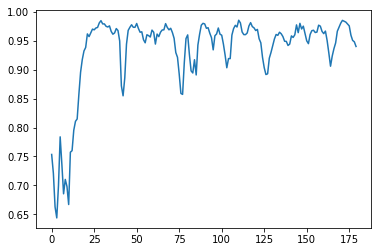

In [25]:
plt.plot(acc_list[::]);

(0.95, 1)

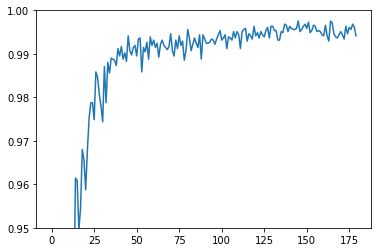

In [26]:
plt.plot(bce_acc_list[::]);
plt.ylim([0.95, 1])

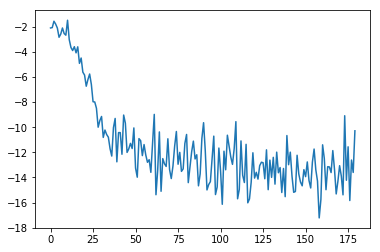

In [27]:
plt.plot(loss_list[::]);

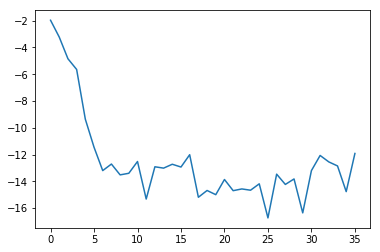

In [28]:
plt.plot(overall_val_loss_list);

## Plots for model output

In [29]:
test_loss_list = []
test_acc_list = []

model.eval()
bce_model.eval()
for test_inputs, test_true_labels in test_loader:

    if test_inputs.shape[0] < batch_size:
        break
    test_hidden = model.init_hidden(batch_size)
    test_hidden = tuple([each.data for each in test_hidden])

    test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
    test_predictions, test_hidden = model(test_inputs, test_hidden)
    test_predictions_bce, test_hidden = bce_model(test_inputs, test_hidden)
    
model.train()
bce_model.train();

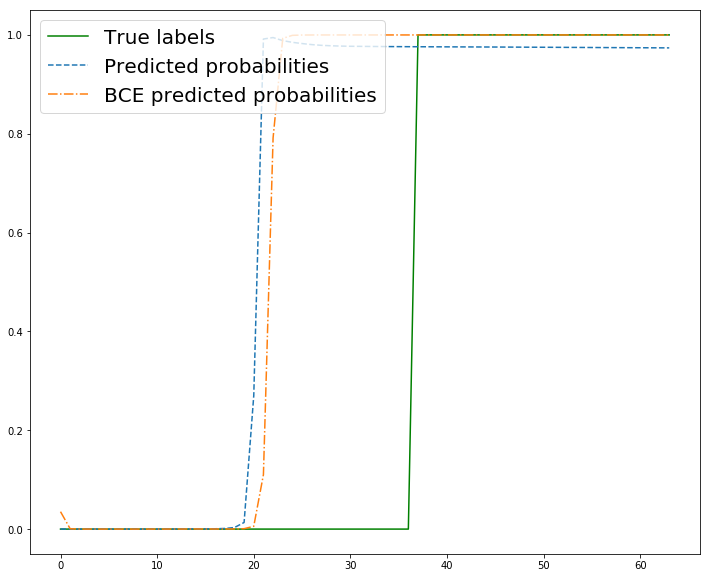

In [30]:
index = 15
plt.figure(figsize=(12, 10))
plt.plot(test_true_labels[index].cpu().detach().numpy(), color='green', label='True labels')
plt.plot(test_predictions[index].cpu().detach().numpy(), '--', label='Predicted probabilities')
plt.plot(test_predictions_bce[index].cpu().detach().numpy(), '-.', label='BCE predicted probabilities')
plt.legend(loc='upper left', fontsize=20);
plt.ylim([-.05, 1.05]);

## Calculate metrics for different models

In [31]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [32]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size)

In [33]:
def get_quality_metrics(test_loader, model, threshold=0.5):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
        test_hidden = model.init_hidden(batch_size)
        test_hidden = tuple([each.data for each in test_hidden])

        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
        test_predictions, test_hidden = model(test_inputs, test_hidden)
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [34]:
(positive_number, negative_number, test_loss, 
test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, 0.1)
    
print("Positive number: ", positive_number)
print("Negative number: ", negative_number)
print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}".format(test_acc))
print("Test delay: {:.2f}".format(mean_delay))
print("Test FP delay: {:.2f}".format(mean_fp_delay))
print("Test FP: ", fp_number)
print("Test FN: ", fn_number)

# custom loss metrics:
# Test loss: -18.444
# Test accuracy: 0.850%
# Test delay: 0.05
# Test FP:  93
# Test FN:  0

Positive number:  40
Negative number:  24
Test loss: -10.253
Test accuracy: 0.713
Test delay: 0.23
Test FP delay: 20.50
Test FP:  53
Test FN:  0


In [35]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

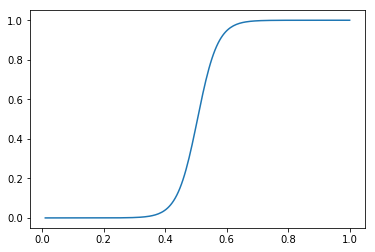

In [36]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [53]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

In [54]:
(fp_number_list, fn_number_list, 
 delay_list, fp_delay_list) = get_pareto_metrics_for_threshold(model, final_test_loader, threshold_list)

3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.999982081308285 0 41 40.73170731707317 64.0
0.9999845888212858 0 41 40.73170731707317 64.0
0.9999867454415872 0 41 40.73170731707317 64.0
0.9999886002706894 0 41 40.73170731707317 64.0
0.9999901955394834 0 41 40.73170731707317 64.0
0.9999915675695499 0 41 40.73170731707317 64.0
0.9999927475999804 0 41 40.73170731707317 64.0
0.9999937624985265 0 41 40.73170731707317 64.0
0.9999946353732554 0 41 40.73170731707317 64.0
0.99999538609863 0 41 40.73170731707317 64.0
0.9999960317679817 0 41 40.73170731707317 64.0
0.9999965870826732 0 41 40.73170731707317 64.0
0.9999970646868129 0 41 40.73170731707317 64.0
0.9999974754551293 0 41 40.73170731707317 64.0
0.9999978287405701 0 41 40.73170731707317 64.0
0.99999813258725 0 41 40.73170731707317 64.0
0.999998393913605 0 41 40.73170731707317 64.0
0.9999986186699144 0 41 40.73170731707317 64.0
0.9999988119737823 0 41 40.73170731707317 64.0
0.9999989782266594 0 41 40.73170731707317 64.0
0.9999991212140611 0 41 40.73170731707317 64.0
0.9999992441917592 

In [55]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_combined, fn_number_list_combined, 
 delay_list_combined, fp_delay_list_combined) = get_pareto_metrics_for_threshold(combined_model, final_test_loader, 
                                                                                             threshold_list)

3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.9999901955394834 0 41 40.73170731707317 64.0
0.9999915675695499 0 41 40.73170731707317 64.0
0.9999927475999804 0 41 40.73170731707317 64.0
0.9999937624985265 0 41 40.73170731707317 64.0
0.9999946353732554 0 41 40.73170731707317 64.0
0.99999538609863 0 41 40.73170731707317 64.0
0.9999960317679817 0 41 40.73170731707317 64.0
0.9999965870826732 0 41 40.73170731707317 64.0
0.9999970646868129 0 41 40.73170731707317 64.0
0.9999974754551293 0 41 40.73170731707317 64.0
0.9999978287405701 0 41 40.73170731707317 64.0
0.99999813258725 0 41 40.73170731707317 64.0
0.999998393913605 0 41 40.73170731707317 64.0
0.9999986186699144 0 41 40.73170731707317 64.0
0.9999988119737823 0 41 40.73170731707317 64.0
0.9999989782266594 0 41 40.73170731707317 64.0
0.9999991212140611 0 41 40.73170731707317 64.0
0.9999992441917592 0 41 40.73170731707317 64.0
0.9999993499599145 0 41 40.73170731707317 64.0
0.9999994409268332 0 41 40.73170731707317 64.0
0.9999995191638043 0 41 40.73170731707317 64.0
0.99999958645226 0

In [56]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_bce, fn_number_list_bce, 
 delay_list_bce, fp_delay_list_bce) = get_pareto_metrics_for_threshold(bce_model, final_test_loader, 
                                                                       threshold_list)



3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.99999538609863 0 41 40.73170731707317 64.0
0.9999960317679817 0 41 40.73170731707317 64.0
0.9999965870826732 0 41 40.73170731707317 64.0
0.9999970646868129 0 41 40.73170731707317 64.0
0.9999974754551293 0 41 40.73170731707317 64.0
0.9999978287405701 0 41 40.73170731707317 64.0
0.99999813258725 0 41 40.73170731707317 64.0
0.999998393913605 0 41 40.73170731707317 64.0
0.9999986186699144 0 41 40.73170731707317 64.0
0.9999988119737823 0 41 40.73170731707317 64.0
0.9999989782266594 0 41 40.73170731707317 64.0
0.9999991212140611 0 41 40.73170731707317 64.0
0.9999992441917592 0 41 40.73170731707317 64.0
0.9999993499599145 0 41 40.73170731707317 64.0
0.9999994409268332 0 41 40.73170731707317 64.0
0.9999995191638043 0 41 40.73170731707317 64.0
0.99999958645226 0 41 40.73170731707317 64.0
0.9999996443243392 0 41 40.73170731707317 64.0
0.999999694097773 0 41 40.73170731707317 64.0


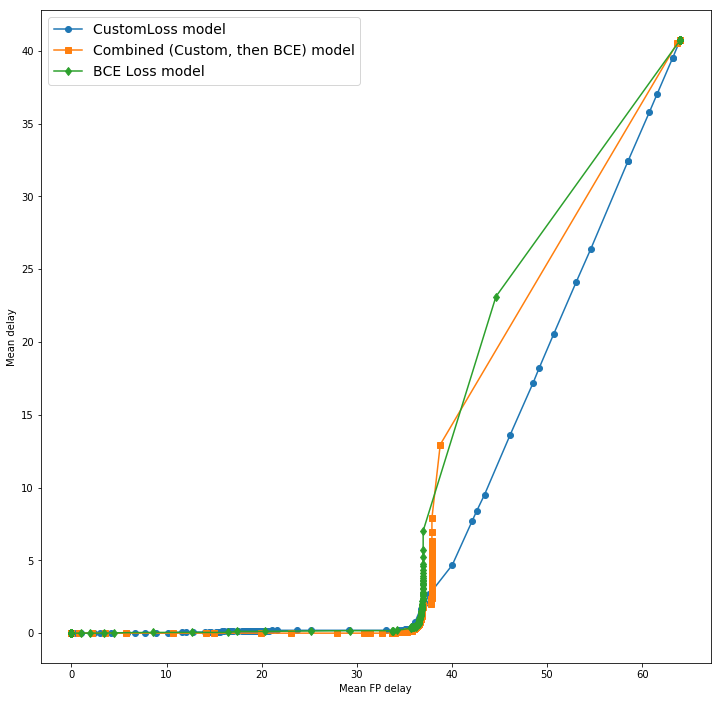

In [60]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list, delay_list, '-o', label='CustomLoss model')
plt.plot(fp_delay_list_combined, delay_list_combined, '-s', label='Combined (Custom, then BCE) model')
plt.plot(fp_delay_list_bce, delay_list_bce, '-d', label='BCE Loss model')
# plt.ylim([0, 25])
# plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
# plt.xlim([32, 40])
plt.legend(loc='upper left', fontsize=14);

In [43]:
# threshold_number = 50
# fp_number_list_random = []
# fn_number_list_random = []
# for threshold in np.linspace(0.9, 1, threshold_number):
#     print(threshold)
#     # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)
    
#     (positive_number, negative_number, test_loss, 
#      test_acc, mean_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)
    
#     fp_number_list_random.append(fp_number)
#     fn_number_list_random.append(fn_number)

In [ ]:
# plt.figure(figsize=(12, 12))
# plt.plot(fp_number_list, fn_number_list, 'o', label='CustomLoss model')
# plt.plot(fp_number_list_bce, fn_number_list_bce, 'd', label='BCE Loss model')
# # plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
# plt.xlabel('FP')
# plt.ylabel('FN')
# plt.legend(loc='upper right', fontsize=20)

In [ ]:
# plt.figure(figsize=(12, 12))
# plt.plot(fp_number_list, delay_list, '-o', label='CustomLoss model')
# plt.plot(fp_number_list_combined, delay_list_combined, '-o', label='Combined (Custom, then BCE) model')
# plt.plot(fp_number_list_bce, delay_list_bce, '--d', label='BCE Loss model')
# # plt.ylim([0, 25])
# # plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
# plt.xlabel('FP')
# plt.ylabel('Mean delay')
# plt.yscale('log')
# plt.legend(loc='upper right', fontsize=20);